In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [2]:
num_workers = 4

batch_size = 128
default_learning_rate = 0.1

In [3]:
from torch import nn
import numpy as np
import torch
import vgg
import os
import sys
import random
from tqdm import tqdm as tqdm
from util import get_number_of_parameters, get_accuracy, set_random_seeds
from IPython import display

In [4]:
# add our package dir to path
module_path = os.path.dirname(os.getcwd())
sys.path.append(module_path)

home_path = module_path
figures_path = os.path.join(home_path, 'reports', 'figures')
models_path = os.path.join(home_path, 'reports', 'models')

In [5]:
device_id = 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=str(device_id)

device = torch.device("cuda:{}".format(device_id) if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device_id))

cuda:0
NVIDIA GeForce RTX 3090 Ti


In [6]:
from data import get_cifar_loader

In [7]:
train_loader = get_cifar_loader(batch_size=batch_size, train=True)
val_loader = get_cifar_loader(batch_size=batch_size, train=False)

Files already downloaded and verified
Files already downloaded and verified


tensor([[[-0.1059, -0.1451, -0.1686,  ..., -0.3804, -0.3255, -0.3961],
         [-0.2000, -0.2157, -0.2392,  ..., -0.3961, -0.3255, -0.4118],
         [-0.0745, -0.2314, -0.2549,  ..., -0.2627, -0.3176, -0.4510],
         ...,
         [ 0.0510,  0.0196, -0.0431,  ..., -0.0039, -0.0745, -0.0902],
         [ 0.0039,  0.0510,  0.1373,  ..., -0.0902, -0.0745, -0.0353],
         [-0.1137, -0.0667,  0.3569,  ..., -0.0745, -0.0588,  0.0353]],

        [[-0.0588, -0.0353, -0.0275,  ..., -0.4039, -0.3647, -0.4588],
         [-0.1686, -0.1294, -0.1137,  ..., -0.4118, -0.3647, -0.4510],
         [-0.0353, -0.1451, -0.1216,  ..., -0.2863, -0.3569, -0.4745],
         ...,
         [ 0.0667,  0.0353, -0.0196,  ...,  0.0118, -0.0588, -0.0824],
         [ 0.0039,  0.0510,  0.1373,  ..., -0.0824, -0.0667, -0.0431],
         [-0.1137, -0.0745,  0.3490,  ..., -0.0745, -0.0588,  0.0196]],

        [[-0.3569, -0.5373, -0.5608,  ..., -0.3647, -0.3412, -0.4667],
         [-0.3412, -0.5216, -0.5686,  ..., -0

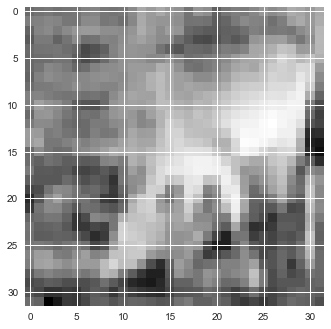

In [8]:
for X,y in train_loader:
    print(X[0])
    print(y[0])
    print(X[0].shape)
    label = X
    target = y
    plt.imshow(np.array(X[0,0,:,:]))
    print(X[0].max())
    print(X[0].min())
    break

In [10]:
model = vgg.VGG_A()
get_number_of_parameters(model)

9750922

In [11]:
model = vgg.VGG_A_Batch()
get_number_of_parameters(model)

9758474

In [12]:
model = vgg.VGG_A_Layer(label[0].shape)
get_number_of_parameters(model)

10056074

In [15]:
def train(model,
          optimizer,
          criterion,
          train_loader,
          val_loader,
          scheduler=None,
          epochs_n=100,
          best_model_path=None):

    model.to(device)
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    batches_n = len(train_loader)
    grads = []
    for epoch in tqdm(range(epochs_n), unit='epoch'):
        if scheduler is not None:
            scheduler.step()
        model.train()
        grad = []
        learning_curve[epoch] = 0
        for data in train_loader:

            #print(data)

            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            #print(loss.item())
            #loss_list.append(loss.item())
            learning_curve[epoch] += loss.item()
            loss.backward()
            grad.append(model.stage6[4].weight.grad.cpu().clone())
            optimizer.step()
        grads.append(grad)
        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        learning_curve[epoch] /= batches_n
        axes[0].plot(learning_curve)

        model.eval()
        train_accuracy_curve[epoch] = get_accuracy(model, train_loader, device)
        val_accuracy_curve[epoch] = get_accuracy(model, val_loader, device)

        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
            if best_model_path:
                torch.save(model.state_dict(), best_model_path)

        axes[1].set_title('Train {:.4f}, val {:.4f}, max val {:.4f} at {}'.format(
            train_accuracy_curve[epoch], val_accuracy, max_val_accuracy, max_val_accuracy_epoch))
        axes[1].plot(train_accuracy_curve)
        axes[1].plot(val_accuracy_curve)

        plt.tight_layout()
        plt.show()
    return grads

In [16]:
def train_batch(model,
                optimizer,
                criterion,
                train_loader,
                val_loader,
                scheduler=None,
                epochs_n=100,
                best_model_path=None):

    model.to(device)
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    batches_n = len(train_loader)
    grads = []
    for epoch in tqdm(range(epochs_n), unit='epoch'):
        if scheduler is not None:
            scheduler.step()
        model.train()
        grad = []
        learning_curve[epoch] = 0
        for data in train_loader:

            #print(data)

            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            #print(loss.item())
            #loss_list.append(loss.item())
            learning_curve[epoch] += loss.item()
            loss.backward()
            grad.append(model.stage6[6].weight.grad.cpu().clone())
            optimizer.step()
        grads.append(grad)
        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        learning_curve[epoch] /= batches_n
        axes[0].plot(learning_curve)

        model.eval()
        train_accuracy_curve[epoch] = get_accuracy(model, train_loader, device)
        val_accuracy_curve[epoch] = get_accuracy(model, val_loader, device)

        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
            if best_model_path:
                torch.save(model.state_dict(), best_model_path)

        axes[1].set_title('Train {:.4f}, val {:.4f}, max val {:.4f} at {}'.format(
            train_accuracy_curve[epoch], val_accuracy, max_val_accuracy, max_val_accuracy_epoch))
        axes[1].plot(train_accuracy_curve)
        axes[1].plot(val_accuracy_curve)

        plt.tight_layout()
        plt.show()
    return grads

In [17]:
epo = 20

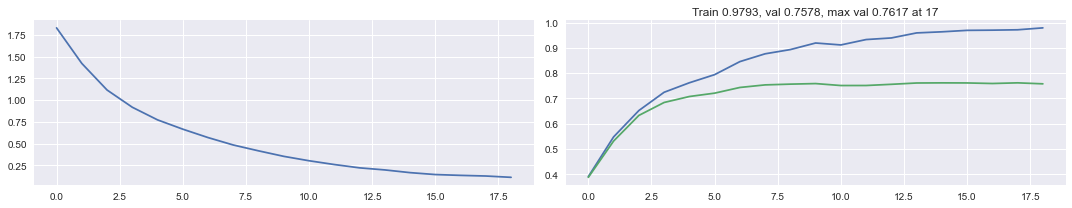

 95%|█████████▌| 19/20 [12:30<00:38, 38.45s/epoch]

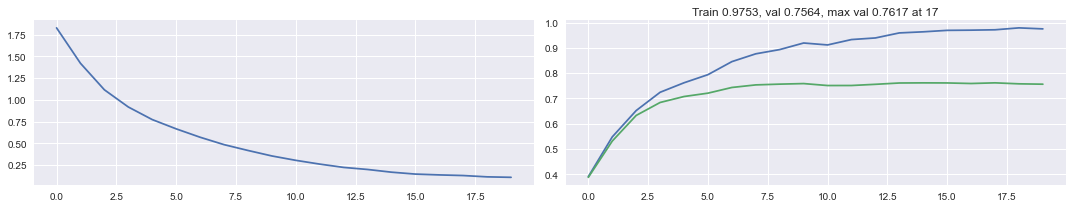

100%|██████████| 20/20 [13:08<00:00, 39.44s/epoch]


In [18]:
os.path.join(os.getcwd(), 'best_vgg_1.pt') #change dump name here

set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A()
lr = 0.001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

grads_01 = train(model,
                 optimizer,
                 criterion,
                 train_loader,
                 val_loader,
                 epochs_n=epo)

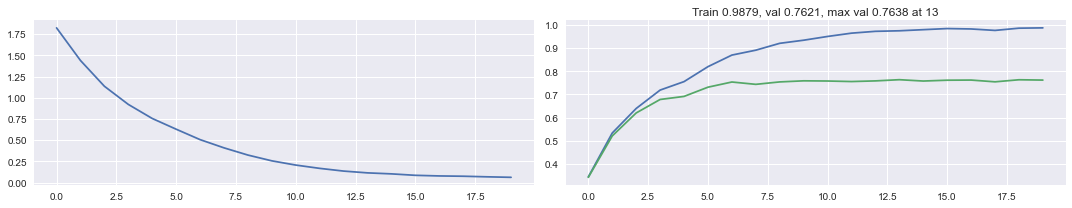

100%|██████████| 20/20 [13:20<00:00, 40.01s/epoch]


In [19]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A()
lr = 0.0005
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

grads_005 = train(model,
                  optimizer,
                  criterion,
                  train_loader,
                  val_loader,
                  epochs_n=epo)

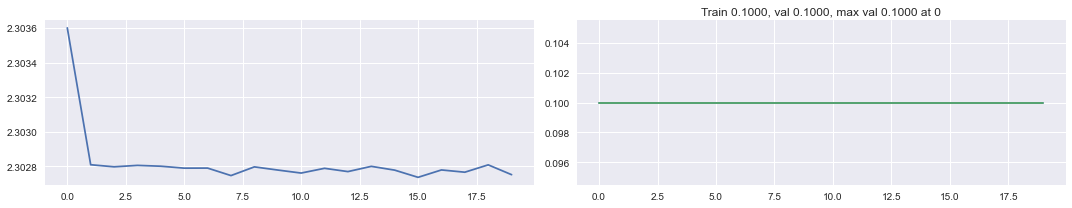

100%|██████████| 20/20 [12:47<00:00, 38.38s/epoch]


In [20]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A()
lr = 0.002
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

grads_02 = train(model,
                 optimizer,
                 criterion,
                 train_loader,
                 val_loader,
                 epochs_n=epo)

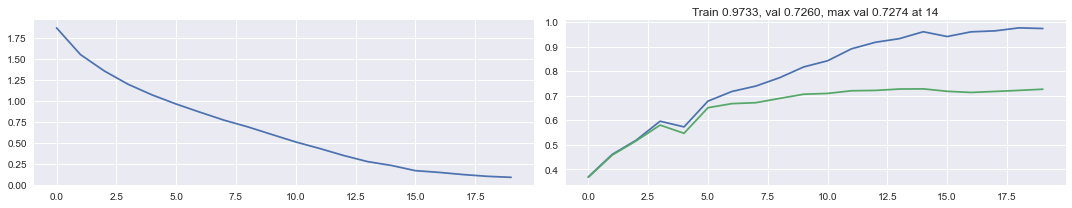

100%|██████████| 20/20 [13:04<00:00, 39.23s/epoch]


In [21]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A()
lr = 0.0001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)


grads_001 = train(model,
                  optimizer,
                  criterion,
                  train_loader,
                  val_loader,
                  epochs_n=epo)

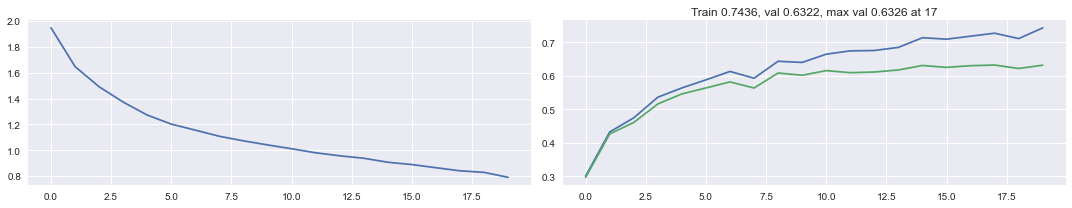

100%|██████████| 20/20 [15:40<00:00, 47.04s/epoch]


In [22]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A()
lr = 0.003
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

grads_03 = train(model,
                 optimizer,
                 criterion,
                 train_loader,
                 val_loader,
                 epochs_n=epo)

In [23]:
#import itertools
lol_01 = np.array(grads_01).flatten()
lol_03 = np.array(grads_03).flatten()
lol_005 = np.array(grads_005).flatten()
lol_001 = np.array(grads_001).flatten()

kek_01 = []
kek_03 = []
kek_005 = []
kek_001 = []
for i in range(1,len(lol_01)):
    kek_01.append((lol_01[i-1] - lol_01[i]).norm(p=2).item())
    kek_03.append((lol_03[i-1] - lol_03[i]).norm(p=2).item())
    kek_005.append((lol_005[i-1] - lol_005[i]).norm(p=2).item())
    kek_001.append((lol_001[i-1] - lol_001[i]).norm(p=2).item())

min_curve = []
max_curve = []
for i in range(len(kek_01)):
    min_curve.append(np.min([kek_01[i], kek_03[i], kek_005[i], kek_001[i]]))
    max_curve.append(np.max([kek_01[i], kek_03[i], kek_005[i], kek_001[i]]))

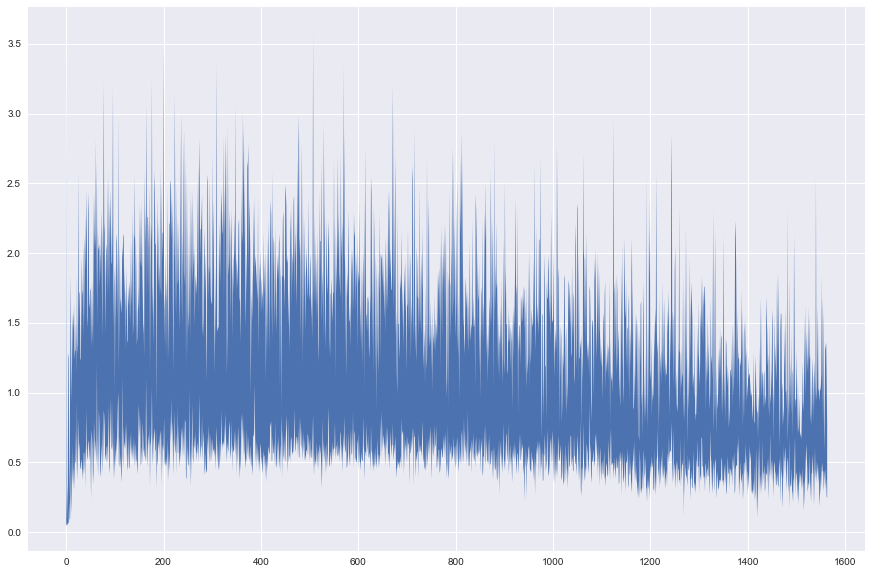

In [24]:
plt.figure(figsize=(15, 10))
plt.fill_between(range(len(min_curve)//5+1), min_curve[::5], max_curve[::5])

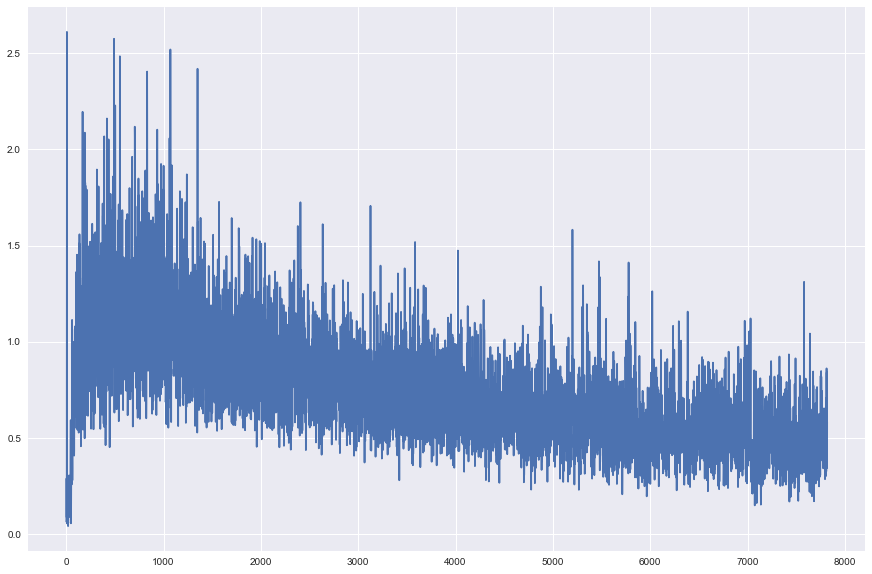

In [25]:
plt.figure(figsize=(15, 10))
plt.plot(range(len(kek_01)), kek_01)

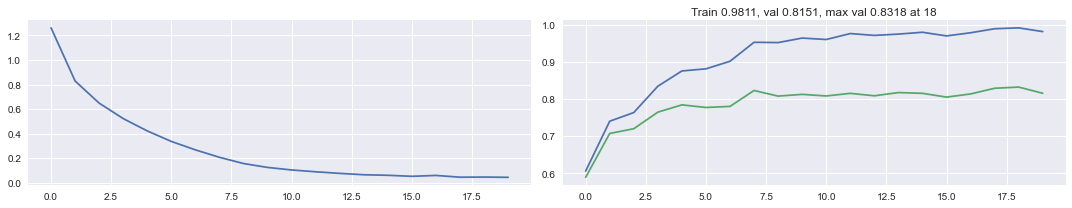

100%|██████████| 20/20 [14:19<00:00, 42.96s/epoch]


In [26]:
os.path.join(os.getcwd(), 'best_vgg_1.pt') #change dump name here

set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Batch()
lr = 0.001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

grads_batch_01 = train_batch(model,
                             optimizer,
                             criterion,
                             train_loader,
                             val_loader,
                             epochs_n=epo)

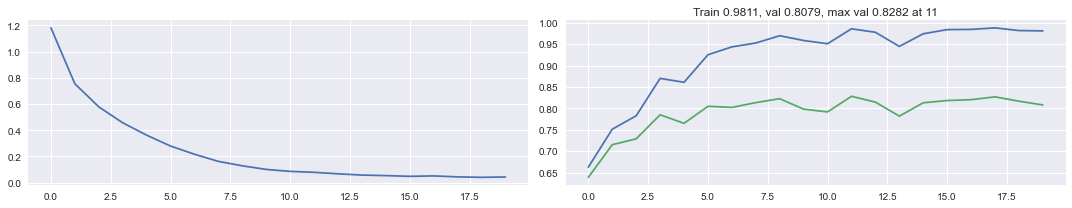

100%|██████████| 20/20 [12:59<00:00, 38.96s/epoch]


In [27]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Batch()
lr = 0.0005
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

grads_batch_005 = train_batch(model,
                              optimizer,
                              criterion,
                              train_loader,
                              val_loader,
                              epochs_n=epo)


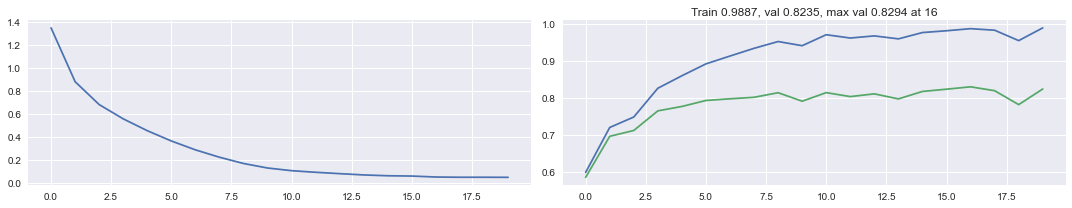

100%|██████████| 20/20 [14:29<00:00, 43.50s/epoch]


In [28]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Batch()
lr = 0.002
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

grads_batch_02 = train_batch(model,
                             optimizer,
                             criterion,
                             train_loader,
                             val_loader,
                             epochs_n=epo)

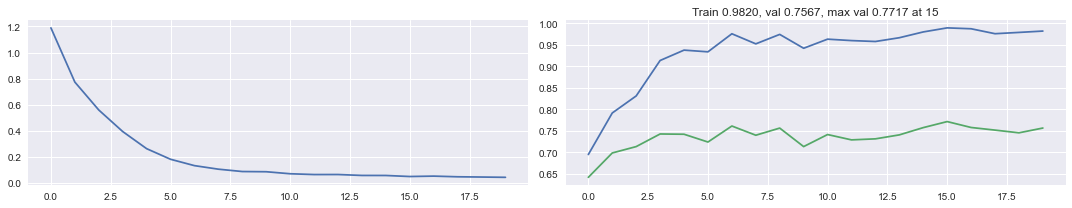

100%|██████████| 20/20 [14:27<00:00, 43.40s/epoch]


In [29]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Batch()
lr = 0.0001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)


grads_batch_001 = train_batch(model,
                              optimizer,
                              criterion,
                              train_loader,
                              val_loader,
                              epochs_n=epo)

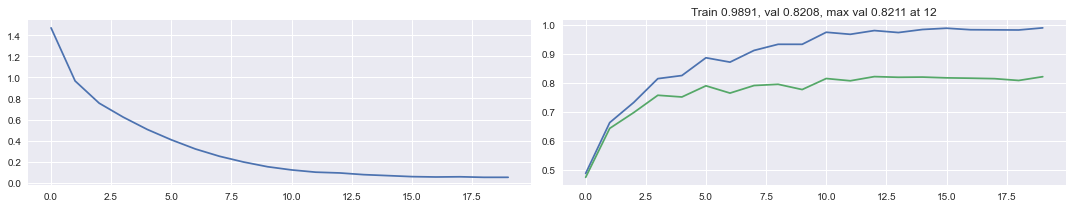

100%|██████████| 20/20 [14:12<00:00, 42.63s/epoch]


In [30]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Batch()
lr = 0.003
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

grads_batch_03 = train_batch(model,
                             optimizer,
                             criterion,
                             train_loader,
                             val_loader,
                             epochs_n=epo)

In [31]:
lol_batch_01 = np.array(grads_batch_01).flatten()
lol_batch_03 = np.array(grads_batch_03).flatten()
lol_batch_005 = np.array(grads_batch_005).flatten()
lol_batch_001 = np.array(grads_batch_001).flatten()

kek_batch_01 = []
kek_batch_03 = []
kek_batch_005 = []
kek_batch_001 = []
for i in range(1,len(lol_01)):
    kek_batch_01.append((lol_batch_01[i-1] - lol_batch_01[i]).norm(p=2).item())
    kek_batch_03.append((lol_batch_03[i-1] - lol_batch_03[i]).norm(p=2).item())
    kek_batch_005.append((lol_batch_005[i-1] - lol_batch_005[i]).norm(p=2).item())
    kek_batch_001.append((lol_batch_001[i-1] - lol_batch_001[i]).norm(p=2).item())

min_batch_curve = []
max_batch_curve = []
for i in range(len(kek_01)):
    min_batch_curve.append(np.min([kek_batch_01[i], kek_batch_03[i], kek_batch_005[i], kek_batch_001[i]]))
    max_batch_curve.append(np.max([kek_batch_01[i], kek_batch_03[i], kek_batch_005[i], kek_batch_001[i]]))

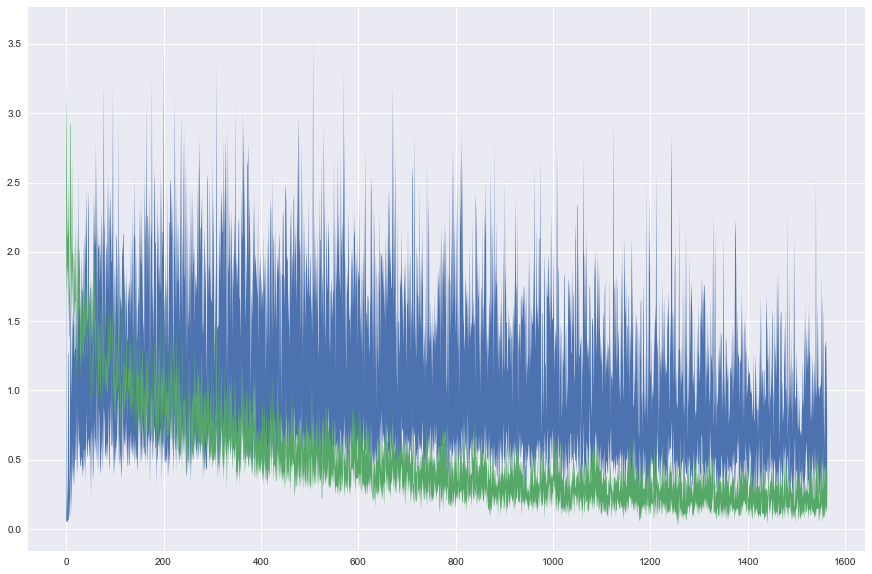

In [32]:
plt.figure(figsize=(15, 10))
plt.fill_between(range(len(min_curve) // 5 + 1), min_curve[::5], max_curve[::5])
plt.fill_between(range(len(min_batch_curve) // 5 + 1), min_batch_curve[::5], max_batch_curve[::5])
plt.show()

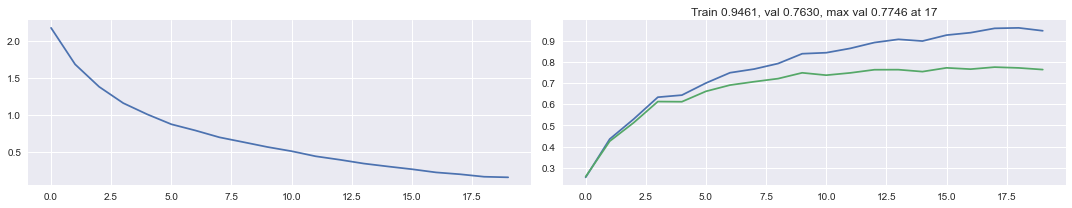

100%|██████████| 20/20 [13:11<00:00, 39.55s/epoch]


In [33]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Layer(label[0].shape)
lr = 0.001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

grads_layer_01 = train_batch(model,
                             optimizer,
                             criterion,
                             train_loader,
                             val_loader,
                             epochs_n=epo)

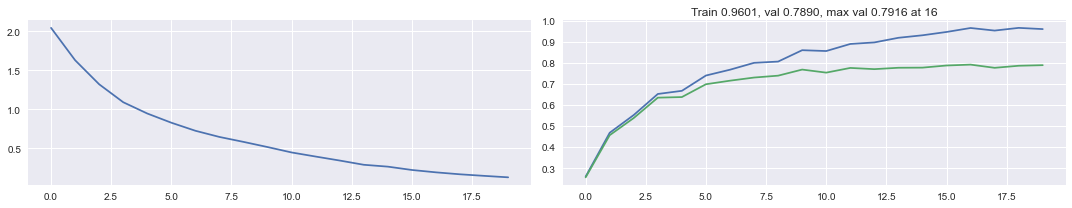

100%|██████████| 20/20 [13:38<00:00, 40.95s/epoch]


In [34]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Layer(label[0].shape)
lr = 0.0005
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

grads_layer_005 = train_batch(model,
                             optimizer,
                             criterion,
                             train_loader,
                             val_loader,
                             epochs_n=epo)

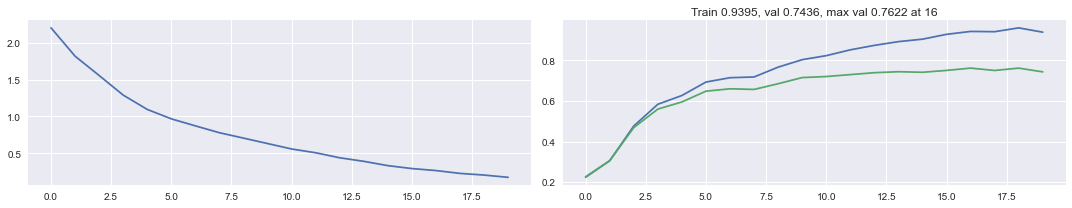

100%|██████████| 20/20 [12:49<00:00, 38.46s/epoch]


In [35]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Layer(label[0].shape)
lr = 0.002
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

grads_layer_02 = train_batch(model,
                              optimizer,
                              criterion,
                              train_loader,
                              val_loader,
                              epochs_n=epo)

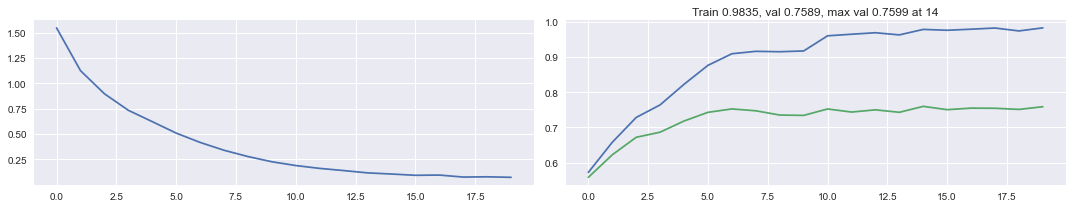

100%|██████████| 20/20 [12:41<00:00, 38.07s/epoch]


In [36]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Layer(label[0].shape)
lr = 0.0001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

grads_layer_001 = train_batch(model,
                             optimizer,
                             criterion,
                             train_loader,
                             val_loader,
                             epochs_n=epo)

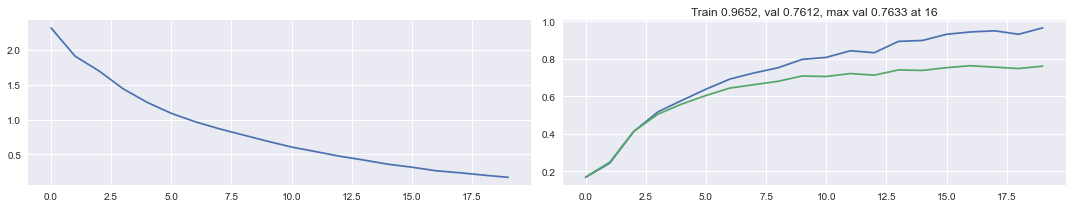

100%|██████████| 20/20 [13:56<00:00, 41.82s/epoch]


In [37]:
set_random_seeds(seed_value=1984, device=device)
model = vgg.VGG_A_Layer(label[0].shape)
lr = 0.003
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

grads_layer_03 = train_batch(model,
                              optimizer,
                              criterion,
                              train_loader,
                              val_loader,
                              epochs_n=epo)

In [38]:
lol_layer_01 = np.array(grads_layer_01).flatten()
lol_layer_03 = np.array(grads_layer_03).flatten()
lol_layer_005 = np.array(grads_layer_005).flatten()
lol_layer_001 = np.array(grads_layer_001).flatten()

kek_layer_01 = []
kek_layer_03 = []
kek_layer_005 = []
kek_layer_001 = []
for i in range(1,len(lol_01)):
    kek_layer_01.append((lol_layer_01[i-1] - lol_layer_01[i]).norm(p=2).item())
    kek_layer_03.append((lol_layer_03[i-1] - lol_layer_03[i]).norm(p=2).item())
    kek_layer_005.append((lol_layer_005[i-1] - lol_layer_005[i]).norm(p=2).item())
    kek_layer_001.append((lol_layer_001[i-1] - lol_layer_001[i]).norm(p=2).item())

min_layer_curve = []
max_layer_curve = []
for i in range(len(kek_01)):
    min_layer_curve.append(np.min([kek_layer_01[i], kek_layer_03[i], kek_layer_005[i], kek_layer_001[i]]))
    max_layer_curve.append(np.max([kek_layer_01[i], kek_layer_03[i], kek_layer_005[i], kek_layer_001[i]]))

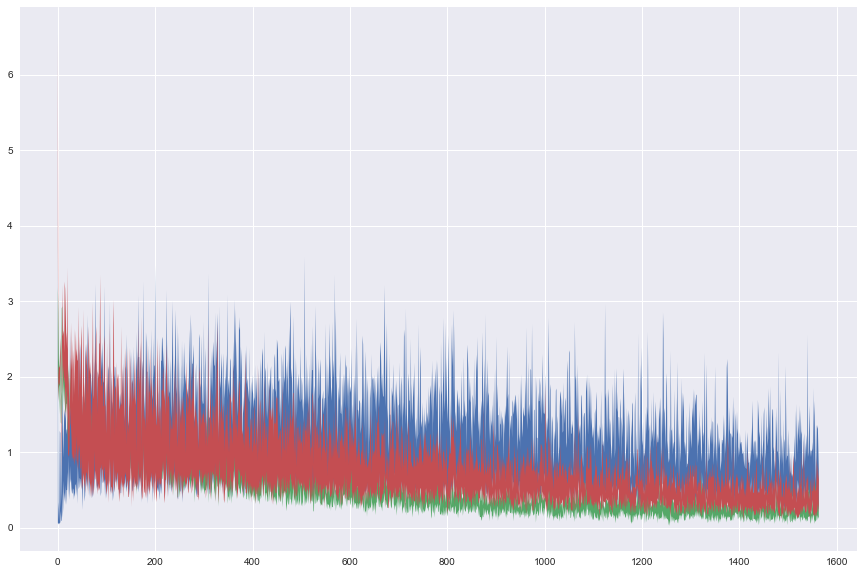

In [39]:
plt.figure(figsize=(15, 10))
plt.fill_between(range(len(min_curve) // 5 + 1), min_curve[::5], max_curve[::5])
plt.fill_between(range(len(min_batch_curve) // 5 + 1), min_batch_curve[::5], max_batch_curve[::5])
plt.fill_between(range(len(min_layer_curve) // 5 + 1), min_layer_curve[::5], max_layer_curve[::5])
plt.show()

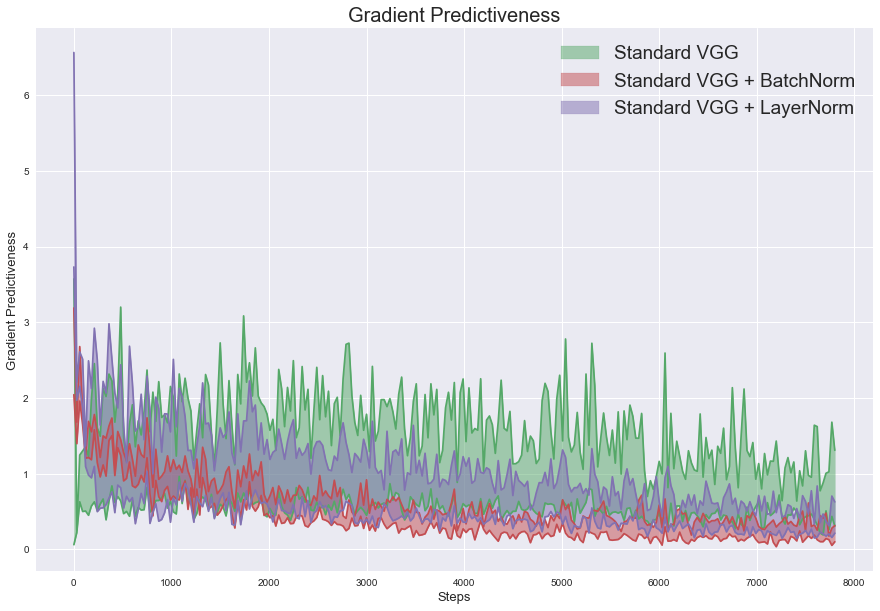

In [44]:
plt.show()
step = 30
steps = np.arange(0, len(min_curve), step)
plt.figure(figsize=(15, 10))
plt.fill_between(steps, min_curve[::step], max_curve[::step],
                 alpha=0.5, color='C1', label='Standard VGG')
plt.plot(steps, min_curve[::step], color='C1')
plt.plot(steps, max_curve[::step], color='C1')

plt.fill_between(steps, min_batch_curve[::step], max_batch_curve[::step],
                 alpha=0.5, color='C2', label='Standard VGG + BatchNorm')
plt.plot(steps, min_batch_curve[::step], color='C2')
plt.plot(steps, max_batch_curve[::step], color='C2')

plt.fill_between(steps, min_layer_curve[::step], max_layer_curve[::step],
                 alpha=0.5, color='C3', label='Standard VGG + LayerNorm')
plt.plot(steps, min_layer_curve[::step], color='C3')
plt.plot(steps, max_layer_curve[::step], color='C3')

plt.legend(fontsize=19)
plt.title('Gradient Predictiveness', fontsize=20)
plt.ylabel('Gradient Predictiveness', fontsize=13)
plt.xlabel('Steps', fontsize=13)
plt.savefig(os.path.join('gradient_predictiveness.png'), dpi=500, quality=100)
plt.show()

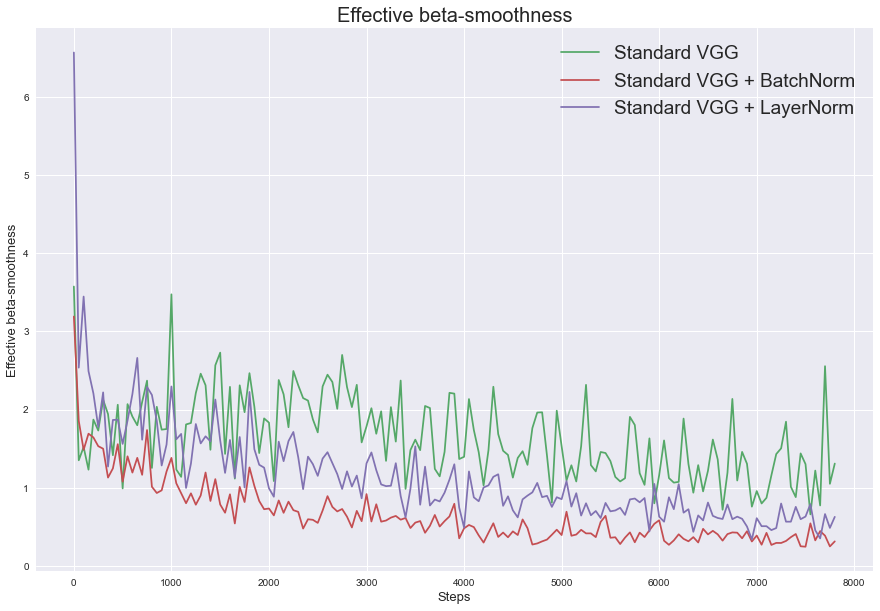

In [47]:
step = 50
steps = np.arange(0, len(min_curve), step)
plt.figure(figsize=(15, 10))

plt.plot(steps, max_curve[::step], color='C1', label='Standard VGG')

plt.plot(steps, max_batch_curve[::step], color='C2', label='Standard VGG + BatchNorm')
plt.plot(steps, max_layer_curve[::step], color='C3', label='Standard VGG + LayerNorm')
plt.legend(fontsize=19)
plt.title('Effective beta-smoothness', fontsize=20)
plt.ylabel('Effective beta-smoothness', fontsize=13)
plt.xlabel('Steps', fontsize=13)
plt.savefig(os.path.join( 'effective_beta_smoothness.png'), dpi=500, quality=100)
plt.show()